### Glucose: ShapDA

In [58]:

import numpy as np
import shap
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression as PLSR
from traintest import *
from metrics import Metrics 
from sklearn.linear_model import BayesianRidge
from visualization import *
import pickle
from dataloader import DataLoad
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Data Loading

In [16]:

D = DataLoad(dataset='glucose')
D.load_data()
Xs, ys, Xt, yt, wl = D.X_source, D.y_source, D.X_target, D.y_target, D.wl

### 2.  Baseline Model

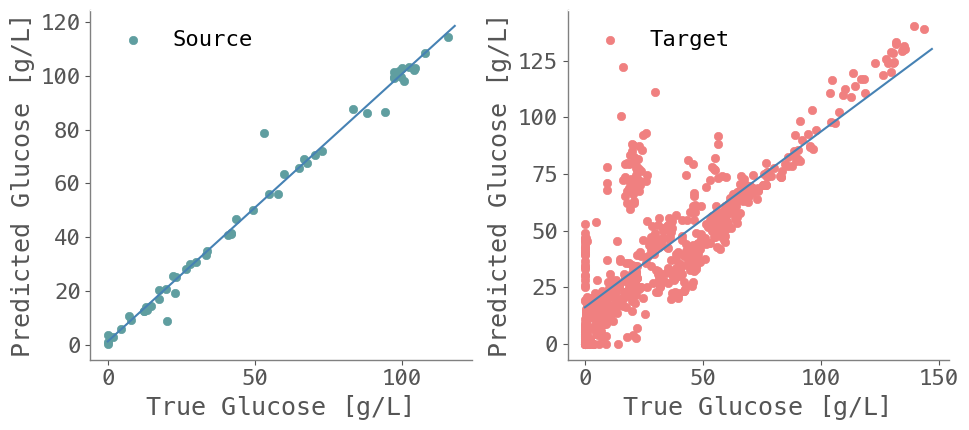

  Test on Model  R-sq  RMSE RMSEP [%]  RPD
0  Source  PLSR  0.99   4.4       3.8  8.3
1  Target  PLSR  0.57  20.4      14.2  1.5


In [ ]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
pls_comp = 12
modelnames=['PLSR']
models = train(Xs_train, ys_train, modelnames=modelnames, plsr_comp=pls_comp)
results = test(models, Xs_test, ys_test, Xt, yt, modelnames=modelnames, figure=True, target='Glucose')
print(results)

### 3. Calculate SHAP Values: Baseline model trained on source data, SHAP explains input data from both source and target

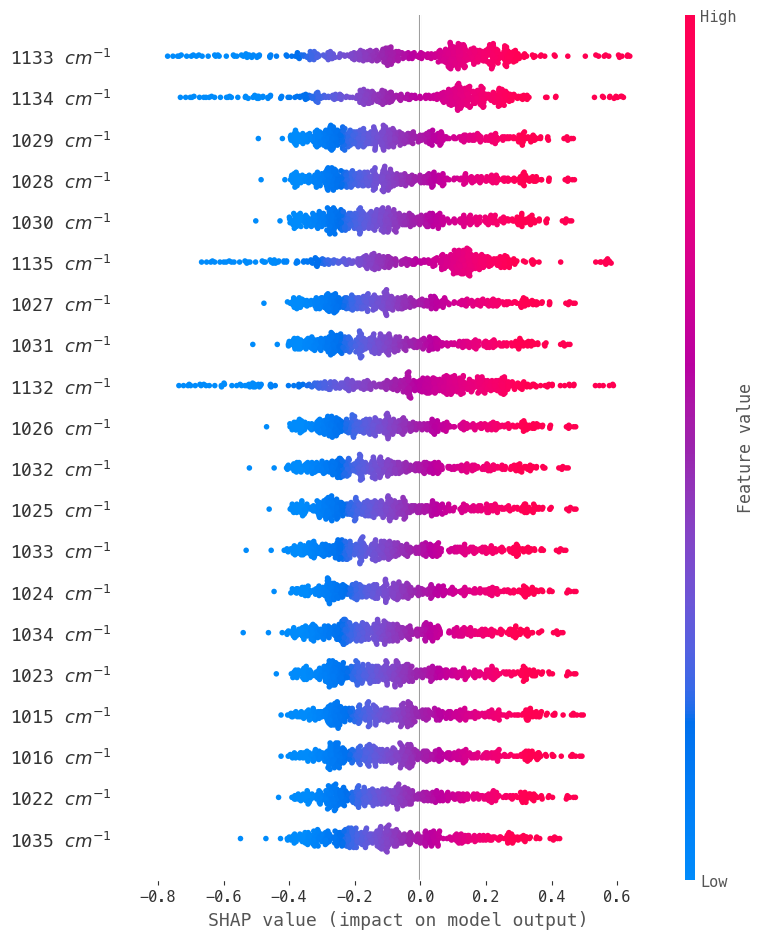

In [ ]:
N = 4 #number of source training data used for SHAP explainer
# SHAP values will be calcualted for the remaining source and all target data
X_mix =  np.vstack((Xs_test, Xs_train[N:,:], Xt[:len(Xs)-N,:])) #Xs_test.copy() #


# Train the regression model using source domain train set (ms)
ms = PLSR(n_components=12) 
ms.fit(Xs_train, ys_train)


# Creating a SHAP explainer with regression model ms, giving only N (=4) datapoits from source train as reference
explainer_s = shap.PermutationExplainer(models[0].predict, Xs_train[:N,:], feature_names=[f"{i}" " $cm^{-1}$" for i in wl])

# Taking rest of Source (train + test) and all of Target data to calculate joint SHAP values
shap_values = explainer_s(X_mix, max_evals=70000)

# To load the explainer object
# with open('./results/shap_permutation_glucose.pkl', 'rb') as f:
#     shap_values = pickle.load(f)
# Visualize the SHAP values
shap.summary_plot(shap_values, X_mix,  feature_names=[f"{i}" " $cm^{-1}$" for i in wl])

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
# Sort features based on mean SHAP values
sorted_indices_s = np.argsort(mean_abs_shap)[::-1]


### 4. Sort Features According to Mean Absolute SHAP Values (MAS)

In [21]:
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
# Sort features based on mean SHAP values
sorted_indices_s = np.argsort(mean_abs_shap)[::-1]

### 5. Vizualization of MAS value Distribution

Feature with best SHAP value: 1133 cm-1
Best SHAP value: 0.2108
Feature with mean SHAP value closest to the mean: 1852 cm-1
Mean SHAP value: 0.0376


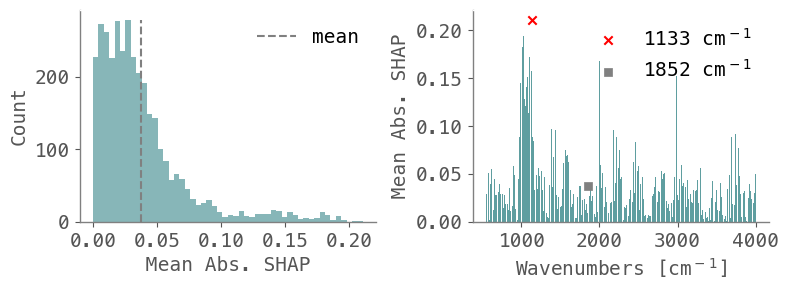

In [22]:
mean_shap_feature_idx = np.argmin(abs(np.mean(mean_abs_shap)  - mean_abs_shap))
wl_mean_shap = wl[mean_shap_feature_idx]
wl_best_shap = wl[sorted_indices_s[0]]

print(f"Feature with best SHAP value: {wl_best_shap} cm-1")
print(f"Best SHAP value: {np.max(mean_abs_shap):.4f}")


print(f"Feature with mean SHAP value closest to the mean: {wl_mean_shap} cm-1")
print(f"Mean SHAP value: {mean_abs_shap[mean_shap_feature_idx]:.4f}")



fig, ax = plt.subplots(1,2, figsize=(8, 3))
# ax.bar(wl[selected_features], mean_abs_shap[selected_features], label=f'Selected {len(selected_features)} features')
ax[1].bar(wl, mean_abs_shap, color='cadetblue')
ax[1].scatter(wl_best_shap, np.max(mean_abs_shap), color='red', marker='x', label=f'{wl_best_shap} cm$^-$$^1$')
ax[1].scatter(wl_mean_shap, np.mean(mean_abs_shap), color='gray',  marker='s', label=f'{wl_mean_shap} cm$^-$$^1$')
# ax.plot(wl, [perc for i in range(len(wl))], c='m', alpha=0.36, label=f'Threshold')
ax[1].legend(frameon=False, fontsize=14)
ax[1].set_xlabel("Wavenumbers [cm$^-$$^1$]", fontsize=14)
ax[1].set_ylabel("Mean Abs. SHAP", fontsize=14)
ax[1].spines['left'].set_color('gray')
ax[1].spines['bottom'].set_color('gray')
ax[1].tick_params(axis='both', labelsize=14)


# Plot the histogram for upper_data (top 0.1% percentile)
# n2, bins2, patches2 = ax.hist(upper_data, bins=50, alpha=0.75,  label='Selected features')
# Plot the histogram for lower_data (below 99.9th percentile)
n1, bins1, patches1 = ax[0].hist(mean_abs_shap, color='cadetblue', bins=50, alpha=0.75)
ax[0].vlines(np.mean(mean_abs_shap), 0, n1.max(), color='gray', linestyle='--', label='mean')
ax[0].set_xlabel('Mean Abs. SHAP', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].legend(frameon=False, fontsize=14)
ax[0].spines['left'].set_color('gray')
ax[0].spines['bottom'].set_color('gray')

plt.tight_layout()
plt.savefig("./figures/shap_value_frequency_distribution_glucose.jpeg", dpi=600)
plt.show()



### 6. Analyzing Two Features: one with highest MAS, ond one with near to the mean of MAS value

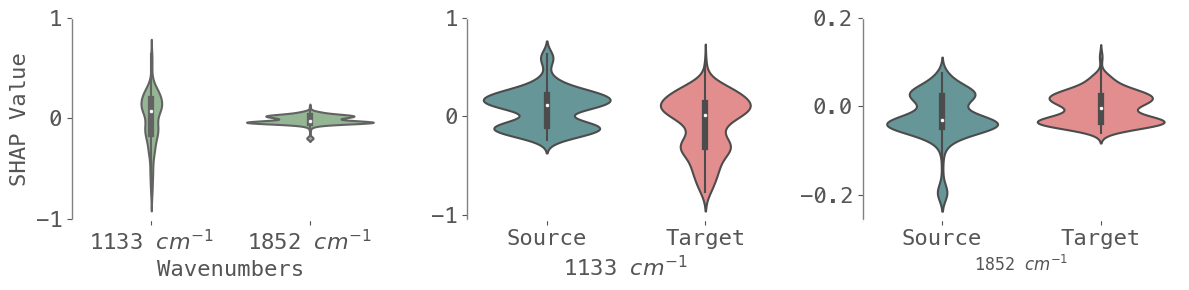

In [23]:
# saving the rank of features 
np.savetxt('./results/feature_index_ranked_glucose.txt', sorted_indices_s, fmt='%.2f', delimiter=',') 
# find the number of source samples used
n_source_data = len(Xs_test) + len(Xs_train[N:,:])
# select two features (from two regions) to compare their influence in decision making process across domains
r1_ind = 0 
r2_ind = mean_shap_feature_idx

r1 = sorted_indices_s[r1_ind]
r2 = sorted_indices_s[r2_ind]

shap_feature1 = shap_values.values[:,r1]
shap_feature2 = shap_values.values[:,mean_shap_feature_idx]

# Violin plot comparison
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.violinplot(data=[shap_feature1, shap_feature2], color='darkseagreen',alpha=0.7, ax=ax[0])
ax[0].set_xticks([0, 1], [f"{wl[r1]}" +  " $cm^{-1}$", f"{wl[mean_shap_feature_idx]}" +  " $cm^{-1}$"], fontsize=16)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xlabel('Wavenumbers',fontsize=16)
ax[0].set_ylabel('SHAP Value',fontsize=16)
ax[0].spines['left'].set_color('gray')
ax[0].tick_params(axis='both', labelsize=16)
## taking region 1:
# seperate for source and target
shap_feature1_s = shap_feature1[:n_source_data]
shap_feature1_t = shap_feature1[n_source_data:]

# Violin plot comparison
sns.violinplot(data=[ shap_feature1_s, shap_feature1_t], palette=['cadetblue', 'lightcoral'], alpha= 0.7,ax=ax[1])
ax[1].set_xticks([0, 1], [  "Source", "Target"])
ax[1].set_xlabel(f"{wl[r1]}" + " $cm^{-1}$", fontsize=16)
ax[1].set_yticks([-1, 0, 1])
ax[1].spines['left'].set_color('gray')
ax[1].tick_params(axis='both', labelsize=16)
## taking region 2:
# seperate for source and target
shap_feature2_s = shap_feature2[:n_source_data]
shap_feature2_t = shap_feature2[n_source_data:]
# Violin plot comparison
sns.violinplot(data=[ shap_feature2_s, shap_feature2_t], palette=['cadetblue', 'lightcoral'], alpha= 0.7, ax=ax[2])
ax[2].set_xticks([0, 1], ["Source", "Target" ])
ax[2].set_xlabel(f"{wl[mean_shap_feature_idx]}" + " $cm^{-1}$")
ax[2].set_yticks([-0.2, 0, 0.2])
ax[2].spines['left'].set_color('gray')
ax[2].tick_params(axis='both', labelsize=16)
# plt.suptitle('SHAP Value Distribution for Glucose', fontsize=16)
plt.tight_layout()
plt.savefig("./figures/shap_violine_glucose.jpeg", dpi=600)
plt.show()

### 7. Find Domain-Invariant Cutoff (k)

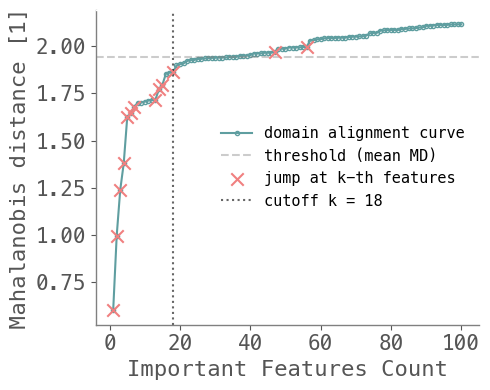

Domain invariant cutoff (k = 18)


In [73]:

domain_invariant_cutoff_k, mahal_results, significant_jumps, mean_md = find_domain_invariant_cutoff(Xs, Xt, sorted_indices_s)
print(f"Domain invariant cutoff (k = {domain_invariant_cutoff_k})")

### 8. Retrain Regression Model using Domain-Invariant Features of source data

Selected size of domain invariant features: 18
 Components 2 and validation error 4.1304
 Components 3 and validation error 4.0543
 Components 4 and validation error 3.9726
 Components 5 and validation error 3.8546
 Components 6 and validation error 3.7789
 Components 7 and validation error 3.7739
 Components 8 and validation error 3.7738
 Components 9 and validation error 3.7729


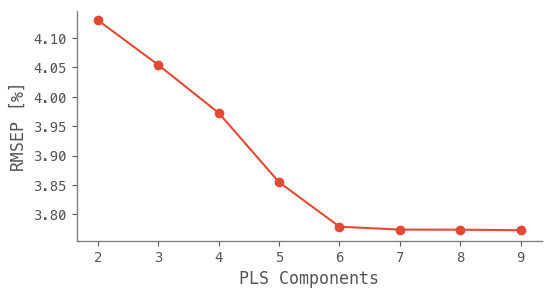

In [64]:
n_dif = domain_invariant_cutoff_k
dif = sorted_indices_s[:n_dif]  # indices of the domain invariant features
print(f"Selected size of domain invariant features: {len(dif)}")
Xs_train_SF, Xs_test_SF, Xt_SF = Xs_train[:,dif], Xs_test[:,dif], Xt[:,dif]
## split of source trainset into validation and train to find the n_components (optional)
rmse_source_test = []
C = range(2, 10)
for k in C:
    ms = PLSR(n_components=k)
    ms.fit(Xs_train_SF, ys_train)
    rmse_source = np.sqrt(MSE(ys_train, ms.predict(Xs_train_SF)))
    print(f" Components {k} and validation error {rmse_source:.4f}")
    rmse_source_test.append(rmse_source)
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(C, rmse_source_test, '-o')
ax.set_xlabel("PLS Components")
ax.set_ylabel("RMSEP [%]")
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.show()

### 9. Test ShapDA Model on Source and Target Domains

In [65]:
models =train(Xs_train_SF, ys_train, modelnames=modelnames, plsr_comp=6)
results = test( models, Xs_test_SF, ys_test, Xt_SF, yt, modelnames=modelnames, figure=False, target='Glucose')
print(results)

  Test on Model  R-sq RMSE RMSEP [%]  RPD
0  Source  PLSR  0.99  4.3       3.7  8.5
1  Target  PLSR  0.97  5.8       4.0  5.4


### 10. Vizualization of Domain Alignment

********** Before adaptation **********


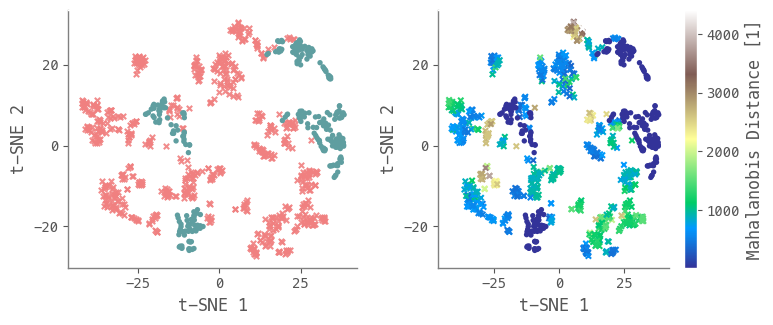

********** After adaptation **********


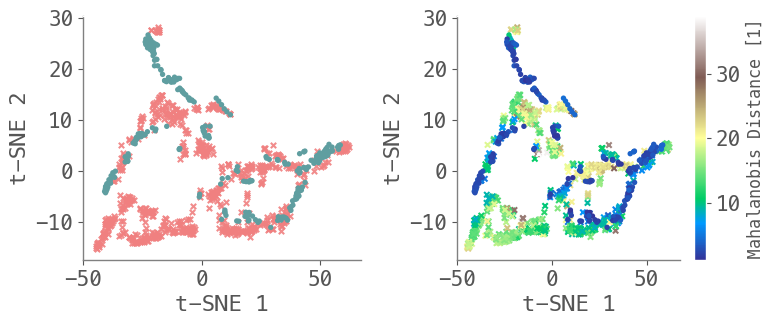

In [66]:

print(f"{'*' * 10} Before adaptation {'*' * 10}")
mds_before, mdt_before = calculate_mahalanobis_distance(Xs, Xt)
visualize_tsne_with_mahal_dist(Xs, Xt, mds_before, mdt_before, title='tSNE_before_da')

print(f"{'*' * 10} After adaptation {'*' * 10}")
Xs_SF = np.vstack(( Xs_train_SF, Xs_test_SF))
mds_after, mdt_after = calculate_mahalanobis_distance(Xs_SF, Xt_SF)
visualize_tsne_with_mahal_dist(Xs_SF, Xt_SF, mds_after, mdt_after, title='tSNE_after_ShapDa_glucose')

********** Before adaptation **********
Mahalanobis distances
Gaussian kernel density estimation


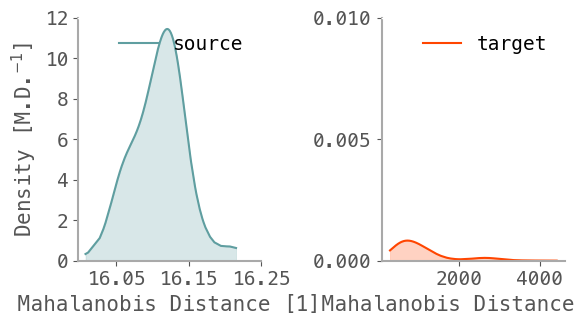

********** After adaptation **********
Mahalanobis distances
Gaussian kernel density estimation


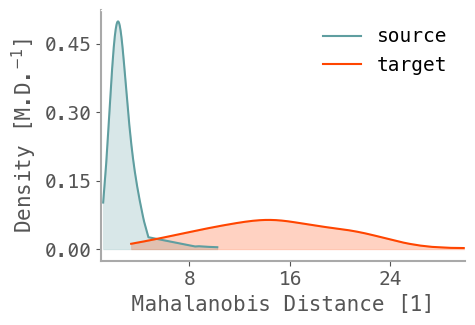

In [67]:
print(f"{'*' * 10} Before adaptation {'*' * 10}")
Gaussian_kernel_density_estimation(mds_before, mdt_before, label_s='source', label_t='target', single_figure=False, title='Before_ShapDa')

print(f"{'*' * 10} After adaptation {'*' * 10}")
Gaussian_kernel_density_estimation(mds_after, mdt_after, label_s='source', label_t='target', single_figure=True, title='After_ShapDa_glucose')


### 11a. Validation of Domain-Invariant Features: impact of increasing number of important features on prediction in target domain

In [68]:
results = []
for k in range(1, 101):
    features = sorted_indices_s[:k]
    if len(features)<20:
        plsr_comp = 6
    else:
        plsr_comp = 8
    models = train(Xs_train[:,features], ys_train, modelnames=['PLSR'], plsr_comp=plsr_comp)
    df = test(models, Xs_test[:,features], ys_test, Xt[:,features], yt, modelnames=['PLSR'], figure=False)
    df['n_features'] = [k for i in range(len(df))]
    results.append(df)
df = pd.concat(results)

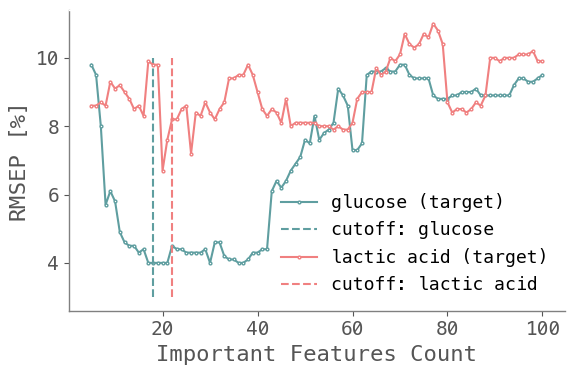

In [69]:
# visualize
S = df[df['Test on']=='Source'].iloc[4:,:]
S_plsr = S[S['Model']=='PLSR']
# S_tf = S[S['Model']=='Transformer']
T = df[df['Test on']=='Target'].iloc[4:,:]
T_plsr = T[T['Model']=='PLSR']
T_tf = T[T['Model']=='Transformer']

T_plsr_lactic = pd.read_csv('./results/shapfs_lacticacid_Features_vs_RMSEP_results.csv')


fig, ax = plt.subplots(1, 1, figsize=(6,4))
# ax[0].scatter(S_plsr['n_features'], [float(i) for i in S_plsr['RMSEP [%]']], color='cadetblue', label='source')
ax.plot(T_plsr['n_features'], [float(i) for i in T_plsr['RMSEP [%]']], '-o', color='cadetblue', markersize=2, markerfacecolor='white',
         markeredgecolor='cadetblue', label='glucose (target)')
ax.vlines(n_dif, 3, 10, color='cadetblue', linestyle='--', label='cutoff: glucose')


ax.plot(T_plsr_lactic['n_features'], [float(i) for i in T_plsr_lactic['RMSEP [%]']], '-o', color='lightcoral', markersize=2, markerfacecolor='white',
         markeredgecolor='lightcoral', label='lactic acid (target)')
ax.vlines(22, 3, 10, color='lightcoral', linestyle='--', label='cutoff: lactic acid')
ax.set_xlabel("Important Features Count", fontsize=16)
ax.set_ylabel("RMSEP [%]", fontsize=16)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='both', labelsize=14)  # You can adjust the value (e.g., 14, 16, etc.)
ax.legend(frameon=False, fontsize=13, loc='lower right')
# ax.set_title('RMSEP vs Cutoff', fontsize=16)
fig.tight_layout()
plt.savefig("./Figures/ShapFS_imp_feat_vs_RMSEP.jpeg", dpi=400)

### 11b. Validation of Domain-Invariant Features: impact of increasing number of important features on identifying domain classes

In [70]:
# Load data
D.load_class_data()
x_train_c, y_train_c, x_test_c, y_test_c, wl_c = D.x_train_c, D.y_train_c, D.x_test_c, D.y_test_c, D.wl_c


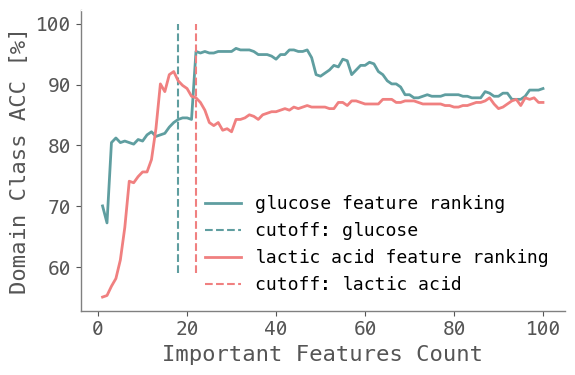

In [71]:
# Test classification
results = []
for k in range(1, 101):
    features = sorted_indices_s[:k]
    acc = classification(x_train_c[:,features], x_test_c[:,features], y_train_c, y_test_c, wl_c[features])[1]
    results.append(acc * 100) # in percentage

# visualize

# Save the results
results_df = pd.DataFrame({'n_features': range(1, 101), 'ACC [%]': results})
results_df.to_csv('./results/shapfs_glucose_classification_results.csv', index=False)
results_lactic = pd.read_csv('./results/shapfs_lacticacid_classification_results.csv')
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(range(1, 101), results, color='cadetblue', linewidth=2, label='glucose feature ranking')
ax.vlines(n_dif, 59, 100, color='cadetblue', linestyle='--', label='cutoff: glucose')
ax.plot(range(1, 101), results_lactic['ACC [%]'], color='lightcoral', linewidth=2, label='lactic acid feature ranking')
ax.vlines(22, 59, 100, color='lightcoral', linestyle='--', label='cutoff: lactic acid')
ax.set_xlabel("Important Features Count", fontsize=16)
ax.set_ylabel("Domain Class ACC [%]", fontsize=16)
ax.tick_params(axis='both', labelsize=14) 
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.legend(frameon=False, loc='lower right', fontsize=13)
# ax.set_title('Domain Classification Accuracy vs Cutoff', fontsize=14)
fig.tight_layout()
plt.savefig("./Figures/ShapFS_imp_feat_vs_domain_classification.jpeg", dpi=700)